In [ ]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Libraries to be used for model evaluation and data scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Libraries to be used for the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# It is used to turn off warnings.
import warnings
warnings.filterwarnings('ignore')

# Tensorflow Warning Blocking
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
df = pd.read_csv("dataset_tesla.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
def check_data(dataframe):
    """
    Display key information about a DataFrame, including shape, head, tail, missing values, and descriptive statistics.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to be checked.

    Returns:
    This function prints the following information:
    1. Information: General information about the DataFrame.
    2. Data Shape: Shape of the DataFrame (number of rows and columns).
    3. The First 5 Data: Display the first 5 rows of the DataFrame.
    4. The Last 5 Data: Display the last 5 rows of the DataFrame.
    5. Missing Values: Display the count of missing values in each column.
    6. Describe the Data: Display basic statistical information about the DataFrame,
       including mean, standard deviation, minimum, maximum, and specified percentiles.

    Example:
    >>> check_data(df)
    """
    print(20 * "-" + "Information".center(20) + 20 * "-")
    print(dataframe.info())
    print(20 * "-" + "Data Shape".center(20) + 20 * "-")
    print(dataframe.shape)
    print("\n" + 20 * "-" + "The First 5 Data".center(20) + 20 * "-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print((dataframe.isnull().sum()).sort_values(ascending=False))
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe([0.01, 0.05, 0.10, 0.50, 0.75, 0.90, 0.95, 0.99]).T)

check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB
None
--------------------     Data Shape     --------------------
(2416, 7)

--------------------  The First 5 Data  --------------------
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21

The date variable is of type object. We must change its type to date. We will only use the date and close variables from the dataset for prediction for daily closings.

##### Data Preparation

In [4]:
# Changing the type of the date variable

df["Date"] = pd.to_datetime(df["Date"])

In [5]:
# Separating the date and close variable from the dataset.

tesla_df = df[["Date", "Close"]]

In [6]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [7]:
# Minimum and maximum dates in the dataset.
print("Minimum Date:", tesla_df["Date"].min())
print("Maximum Date:", tesla_df["Date"].max())

Minimum Date: 2010-06-29 00:00:00
Maximum Date: 2020-02-03 00:00:00


In [8]:
# We need to set the date variable as index and remove it from the variable section.
tesla_df.index = tesla_df["Date"]
tesla_df.drop("Date", axis =1, inplace=True)
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [9]:
# I keep a copy of tesla df called result of. We will need.
result_df = tesla_df.copy()

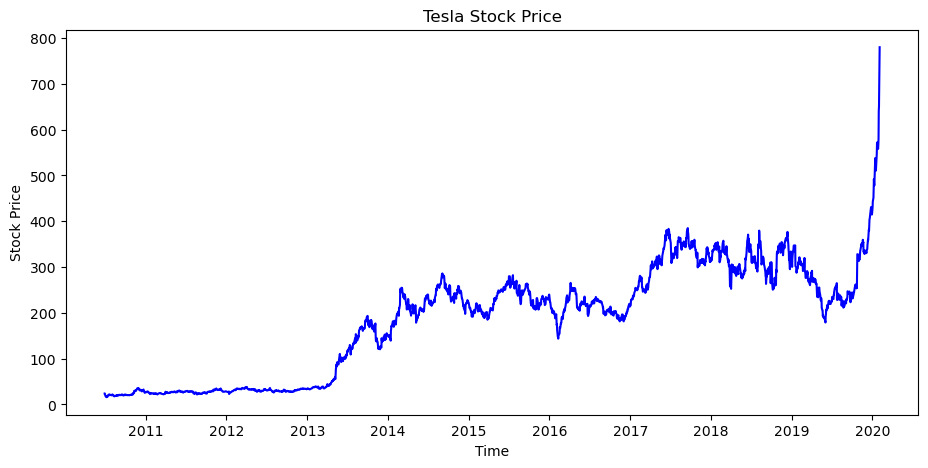

In [10]:
# Visualization

plt.figure(figsize=(11, 5))
plt.plot(tesla_df["Close"], color = "blue");
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price")
plt.xlabel("Time")
plt.show()

In [11]:
# To model using LSTM, we must first convert this data into a numpy array.

tesla_df = tesla_df.values

In [12]:
# The commonly used data structure in neural networks is float32. Let's define the data type as float32."
tesla_df = tesla_df.astype("float32")

In [13]:
tesla_df[0:5] 

array([[23.89],
       [23.83],
       [21.96],
       [19.2 ],
       [16.11]], dtype=float32)

In [14]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [15]:
# Let's divide the dataset as train and test.
train, test, position = split_data(tesla_df, 0.20)
print(train.shape, test.shape)

(1933, 1) (483, 1)


##### Standardization

In [16]:
scaler_train = MinMaxScaler(feature_range = (0, 1))
train = scaler_train.fit_transform(train)

scaler_test = MinMaxScaler(feature_range = (0, 1))
test = scaler_test.fit_transform(test)

In [17]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [18]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [19]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])

    return np.array(X), np.array(Y)

lookback=20 # 20 days

In [20]:
# Train dataset
X_train, y_train = create_features(train, lookback)

In [21]:
# Test dataset
X_test, y_test = create_features(test, lookback)

In [22]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [23]:
X_train[0:2]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611]],
      dtype=float32)

In [24]:
X_train = np.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1]))
y_train =  y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [25]:
print(X_train.shape, X_test.shape, y_test.shape)

(1913, 1, 20) (463, 1, 20) (463, 1)


##### Modelling

In [26]:
model = Sequential()
model.add(LSTM(units=50,
                    activation="relu",
                    input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2)) 
model.add(Dense(1)) 

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Optimization and Evaluation Metrics

In [28]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
callbacks =  [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min",
                              save_best_only=True, save_weights_only=False, verbose=1)]

In [30]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks,
                    shuffle=False) 

Epoch 1/100
50/96 [==============>...............] - ETA: 0s - loss: 0.0046      
Epoch 1: val_loss improved from inf to 0.00372, saving model to mymodel.h5
96/96 [==============================] - 1s 4ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 2/100
50/96 [==============>...............] - ETA: 0s - loss: 0.0035
Epoch 2: val_loss improved from 0.00372 to 0.00314, saving model to mymodel.h5
96/96 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 3/100
55/96 [================>.............] - ETA: 0s - loss: 0.0029
Epoch 3: val_loss improved from 0.00314 to 0.00278, saving model to mymodel.h5
96/96 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 4/100
54/96 [===============>..............] - ETA: 0s - loss: 0.0018    
Epoch 4: val_loss improved from 0.00278 to 0.00271, saving model to mymodel.h5
96/96 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 5/100
54/96 [=======

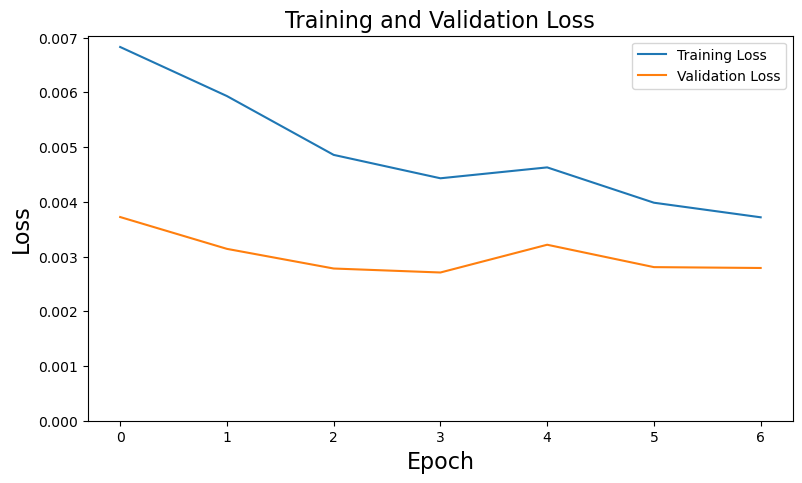

In [31]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

##### Model Evaluation

In [34]:
loss = model.evaluate(X_test, y_test, batch_size=20)
print("\nTest loss: %.1f%%" % (100.0 * loss))

24/24 [==============================] - 0s 1ms/step - loss: 0.0028

Test loss: 0.3%


In [33]:
train_predict = model.predict(X_train) 
test_predict = model.predict(X_test) 

15/15 [==============================] - 0s 784us/step


In [35]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [36]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [37]:
# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

test_rmse= np.sqrt(mean_squared_error(y_test, test_predict))

In [38]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 16.83171272277832
Test RMSE: 31.749290466308594


When we want to make predictions for future periods, the expected error is 32 units

In [39]:
train_prediction_df = result_df[lookback:position]   
train_prediction_df["Predicted"] = train_predict   
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,30.228954
2010-07-29,20.350000,30.212290
2010-07-30,19.940001,30.193073
2010-08-02,20.920000,30.196770
2010-08-03,21.950001,30.219805


In [40]:
test_prediction_df = result_df[position+lookback:]   
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,293.556488
2018-04-04,286.940002,289.497772
2018-04-05,305.720001,289.420227
2018-04-06,299.299988,288.228546
2018-04-09,289.660004,285.556641


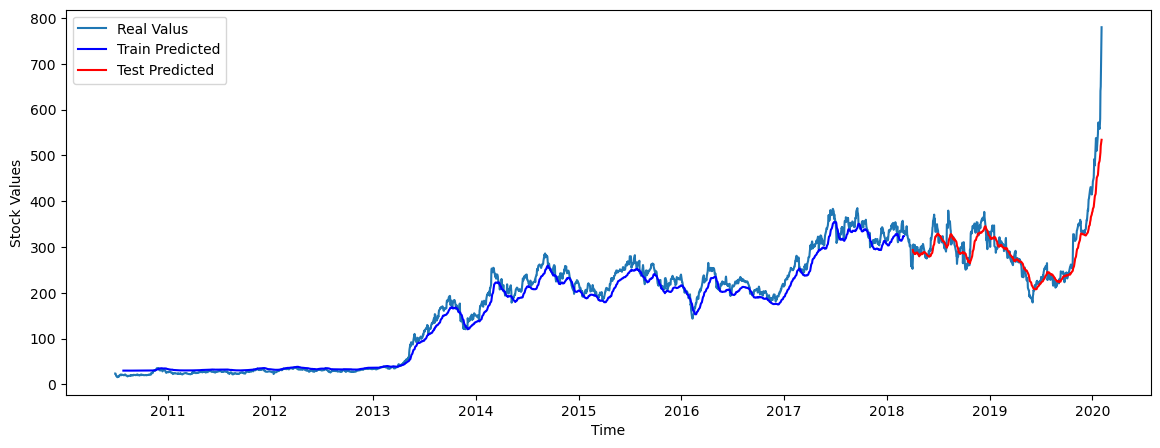

In [41]:
plt.figure(figsize=(14,5))
plt.plot(result_df, label = 'Real Valus')
plt.plot(train_prediction_df["Predicted"], color = "blue", label = "Train Predicted")
plt.plot(test_prediction_df["Predicted"], color = "red", label = "Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()